# Trabalhando com dados de Radar do NuScenes

# Setup

In [1]:
# Caminhos

PATH_DATASET_NUSCENES_MINI = '/home/live/Data/nuScenes'
#PATH_DADOS_RADAR_FRONT = '/home/live/Data/nuScenes/samples/RADAR_FRONT'

In [37]:
# bibliotecas
import os
import pandas as pd

In [26]:
%matplotlib inline
from nuscenes.nuscenes import NuScenes
from nuscenes.utils.data_classes import RadarPointCloud

nusc = NuScenes(version='v1.0-mini', dataroot=PATH_DATASET_NUSCENES_MINI, verbose=True)    #print as informações gerais sobre os dados do meu dataset

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.305 seconds.
Reverse indexing ...
Done reverse indexing in 0.0 seconds.


# Dados Radar

## Visualização dos dados do radar utilizando ferramentas do nuscenes dev toolkit

In [21]:
my_scene = nusc.scene[0]    # seleção de uma Cena
first_sample_token_from_my_scene = my_scene['first_sample_token']   # Seleção do token do primeiro sample
my_sample = nusc.get('sample', first_sample_token_from_my_scene)    # Get do sample, com todos os tokens do sample
sensor2 = 'RADAR_FRONT'     # Especificar o sensor
radar_front_data = nusc.get('sample_data', my_sample['data'][sensor2])  # Get dos dados do Sample, (tipo de estrutura, token), Data é um dict
path_to_file_sensor_data = radar_front_data['filename']         # Caminho para o arquivo com os dados do radar
#print(path_to_file_sensor_data)

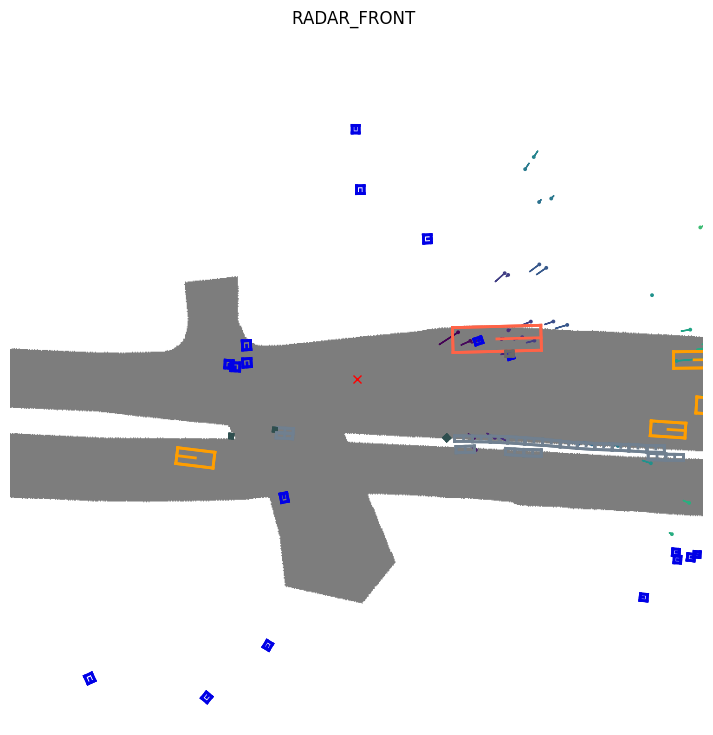

In [22]:
nusc.render_sample_data(radar_front_data['token'])      #renderiza os dados de um sensor a partir do token

## Visualização de dados do radar utilizando ferramentas padrões de rendereização de um arquvio .PCD

PointCloud with 125 points.


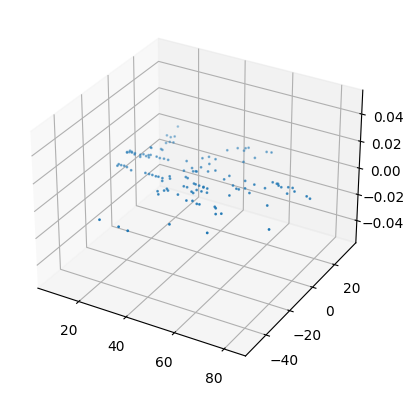

In [32]:
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Carrega o arquivo .pcd
#arquivo_pcd = '/n008-2018-08-01-15-16-36-0400__RADAR_FRONT__1533151603555991.pcd'
pcd = o3d.io.read_point_cloud(PATH_DATASET_NUSCENES_MINI + '/'+ path_to_file_sensor_data)
print(pcd)
pontos = np.asarray(pcd.points)

# Visualiza a nuvem de pontos usando Matplotlib
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pontos[:, 0], pontos[:, 1], pontos[:, 2], s=1)
plt.show()

In [24]:
import plotly.graph_objects as go

# Converte a nuvem de pontos para numpy array
pontos = np.asarray(pcd.points)

# Cria a figura de plotagem usando Plotly
fig = go.Figure(data=[go.Scatter3d(
    x=pontos[:, 0],
    y=pontos[:, 1],
    z=pontos[:, 2],
    mode='markers',
    marker=dict(size=2)
)])

# Configurações da visualização
fig.update_layout(scene=dict(
    xaxis_title='X',
    yaxis_title='Y',
    zaxis_title='Z'
))

# Exibe a figura no Jupyter Notebook
fig.show()

## Acessando os dados do radar

In [45]:
my_scene = nusc.scene[2]    # seleção de uma Cena
first_sample_token_from_my_scene = my_scene['first_sample_token']   # Seleção do token do primeiro sample
my_sample = nusc.get('sample', first_sample_token_from_my_scene)    # Get do sample, com todos os tokens do sample
sensor2 = 'RADAR_FRONT'     # Especificar o sensor
radar_front_data = nusc.get('sample_data', my_sample['data'][sensor2])  # Get dos dados do Sample, (tipo de estrutura, token), Data é um dict
path_to_file_sensor_data = os.path.join(nusc.dataroot, radar_front_data['filename'])    # Caminho para o arquivo com os dados do radar

In [46]:
pc = RadarPointCloud.from_file(path_to_file_sensor_data)        # Ler os dados .pcd e converte em um nd_array
pc = pc.points.T
print(pc.shape)
df_radarPointCould = pd.DataFrame(pc, columns=['x', 'y', 'z', 'dyn_prop', 'id', 'rcs', 'vx', 'vy', 'vx_comp', 'vy_comp', 'is_quality_valid', 'ambig_state', 'x_rms', 'y_rms', 'invalid_state', 'pdh0', 'vx_rms', 'vy_rms'])

(62, 18)


In [47]:
df_radarPointCould.head(10)

,x,y,z,dyn_prop,id,rcs,vx,vy,vx_comp,vy_comp,is_quality_valid,ambig_state,x_rms,y_rms,invalid_state,pdh0,vx_rms,vy_rms
0,6.400000,-3.100000,0.0,1.0,0.0,-3.5,0.0,0.0,0.000633,-0.000306,1.0,3.0,19.0,19.0,0.0,1.0,16.0,3.0
1,8.400000,12.500000,0.0,2.0,1.0,-0.5,-2.0,0.0,-0.622932,-0.926982,1.0,3.0,19.0,19.0,0.0,1.0,18.0,3.0
2,19.799999,-4.500000,0.0,1.0,3.0,-1.0,0.0,0.0,0.000352,-0.000080,1.0,3.0,19.0,19.0,0.0,1.0,16.0,3.0
3,11.400000,-19.299999,0.0,3.0,4.0,18.0,0.0,0.0,0.000701,-0.001187,1.0,3.0,19.0,19.0,0.0,1.0,19.0,3.0
4,21.400000,-9.700000,0.0,1.0,5.0,-2.0,0.0,0.0,0.000607,-0.000275,1.0,3.0,19.0,19.0,0.0,1.0,16.0,3.0
5,16.200001,26.100000,0.0,6.0,6.0,13.0,-6.0,0.0,-1.669383,-2.689562,1.0,3.0,20.0,19.0,0.0,1.0,19.0,3.0
6,28.200001,23.500000,0.0,1.0,8.0,4.0,0.0,0.0,-0.000781,-0.000651,1.0,3.0,19.0,19.0,0.0,1.0,17.0,3.0
7,38.599998,1.100000,0.0,1.0,9.0,12.0,0.0,0.0,-0.000038,-0.000001,1.0,3.0,19.0,19.0,0.0,1.0,16.0,3.0
8,38.599998,-11.100000,0.0,1.0,10.0,6.5,0.0,0.0,0.000431,-0.000124,1.0,3.0,19.0,19.0,0.0,1.0,16.0,3.0
9,23.200001,35.099998,0.0,1.0,11.0,12.0,-1.0,0.0,-0.304780,-0.461111,1.0,3.0,21.0,21.0,0.0,1.0,18.0,3.0
